In [248]:
source("./polyjit.R")
library(RPostgres)
library(ggplot2)
options(repr.plot.family = 'mono', repr.plot.width = 10, repr.plot.height = 10, warn = -1)
con <- dbConnect(RPostgres::Postgres(),
                 dbname="pprof-bb",
                 user="bb",
                 host="debussy.fim.uni-passau.de",
                 port=5432,
                 password="bb")
exps = get_experiments(c = con)

1 - query:  SELECT name, cast(id as VARCHAR) as id, description FROM experiment; 
1 - result set:  16 


In [246]:
experiment = '40033389-023f-4766-b8c0-b5e98a62d0a9'
baseline   = '40033389-023f-4766-b8c0-b5e98a62d0a9'

d = speedup(c = con, base = baseline, jit = experiment, papi = NULL, projects = NULL, groups = NULL)
head(d)

query-speedup (no papi)
2 - query:  SELECT spd.project_name, spd.cores, spd.ptime, spd.time, spd.speedup,
    CASE WHEN spd.speedup >= 0.5 OR spd.speedup = 0 THEN spd.speedup

    WHEN spd.speedup > 0 AND spd.speedup < 0.5 THEN -1/spd.speedup
    END AS speedup_corrected
 FROM
 (
    SELECT pjit.project_name, pjit.cval AS cores,  pjit.sum AS ptime, raw.sum AS time,
           (raw.sum / pjit.sum) AS speedup
    FROM
    (
      SELECT project_name, metrics.name, SUM(metrics.value), config.name,
             cast ( config.value AS INTEGER) AS cval
      FROM run, metrics, config
      WHERE experiment_group = '40033389-023f-4766-b8c0-b5e98a62d0a9' AND run.id = metrics.run_id AND run.id = config.run_id AND metrics.name = 'time.real_s'
      GROUP BY project_name, metrics.name, config.name, cval
    ) AS pjit,
    (
      SELECT project_name, metrics.name, SUM(metrics.value), config.name, cast ( config.value AS INTEGER) AS cval
      FROM run, metrics, config
      WHERE experiment_group 

,project_name,cores,ptime,time,speedup,speedup_corrected
1,employ.simple,3,0.03,0.01,0.3333333,-3
2,employ.simple,10,0.03,0.01,0.3333333,-3
3,employ.simple,8,0.03,0.01,0.3333333,-3
4,employ.simple,7,0.03,0.01,0.3333333,-3
5,employ.simple,6,0.03,0.01,0.3333333,-3
6,cdecl.simple,5,0.02,0.01,0.5,0.5


In [245]:
d.faster <- d[(d$speedup_corrected > 2),]
d.slower <- d[(d$speedup_corrected <= 1),]

get_df <- function(data) {
    dens <- density(data$speedup_corrected)
    df <- data.frame(x=dens$x, y=dens$y)
    probs <- c(0.02, 0.5, 0.98)
    quantiles <- quantile(data$speedup_corrected, prob=probs)
    df$quant <- factor(findInterval(df$x, quantiles))
    return(df)
}

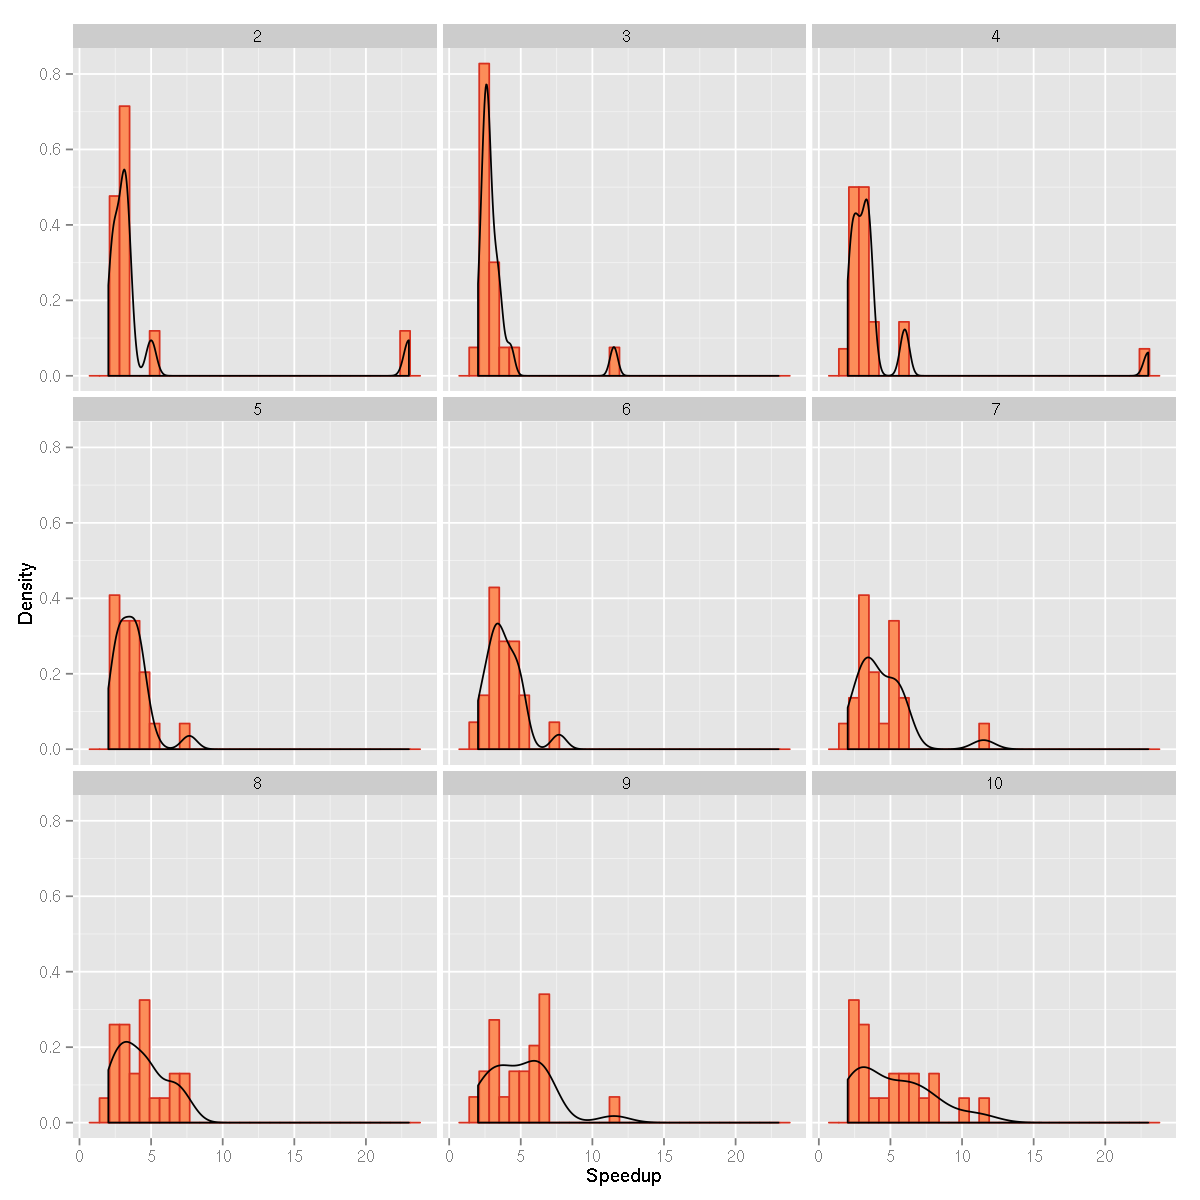

In [233]:
p <- ggplot(data=d.faster, aes(x=speedup_corrected)) +
    geom_histogram(aes(y = ..density..), colour = "#d7301f", fill = "#fc8d59") +
    geom_density() +
    facet_wrap(~ cores, ncol=3) +
    ylab("Density") +
    xlab("Speedup")
p


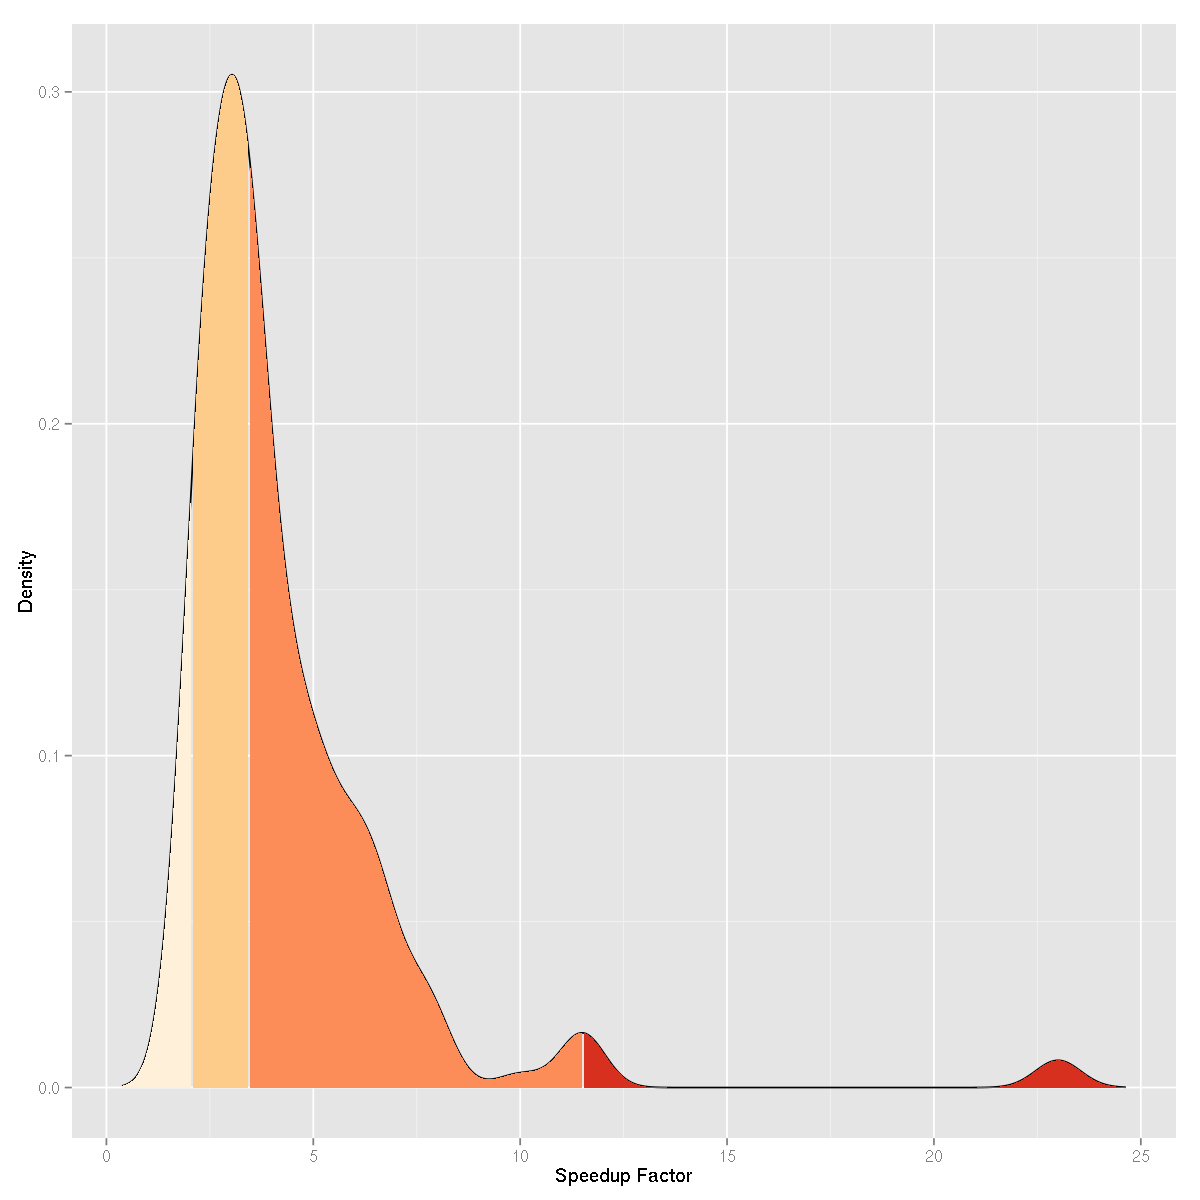

In [241]:
p <- ggplot(data=df.faster, aes(x=x, y=y)) +
    geom_line() +
    geom_ribbon(aes(ymin=0, ymax=y, fill=quant)) +
    scale_fill_brewer(guide="none", palette="OrRd") +
    xlab("Speedup Factor") +
    ylab("Density")
p

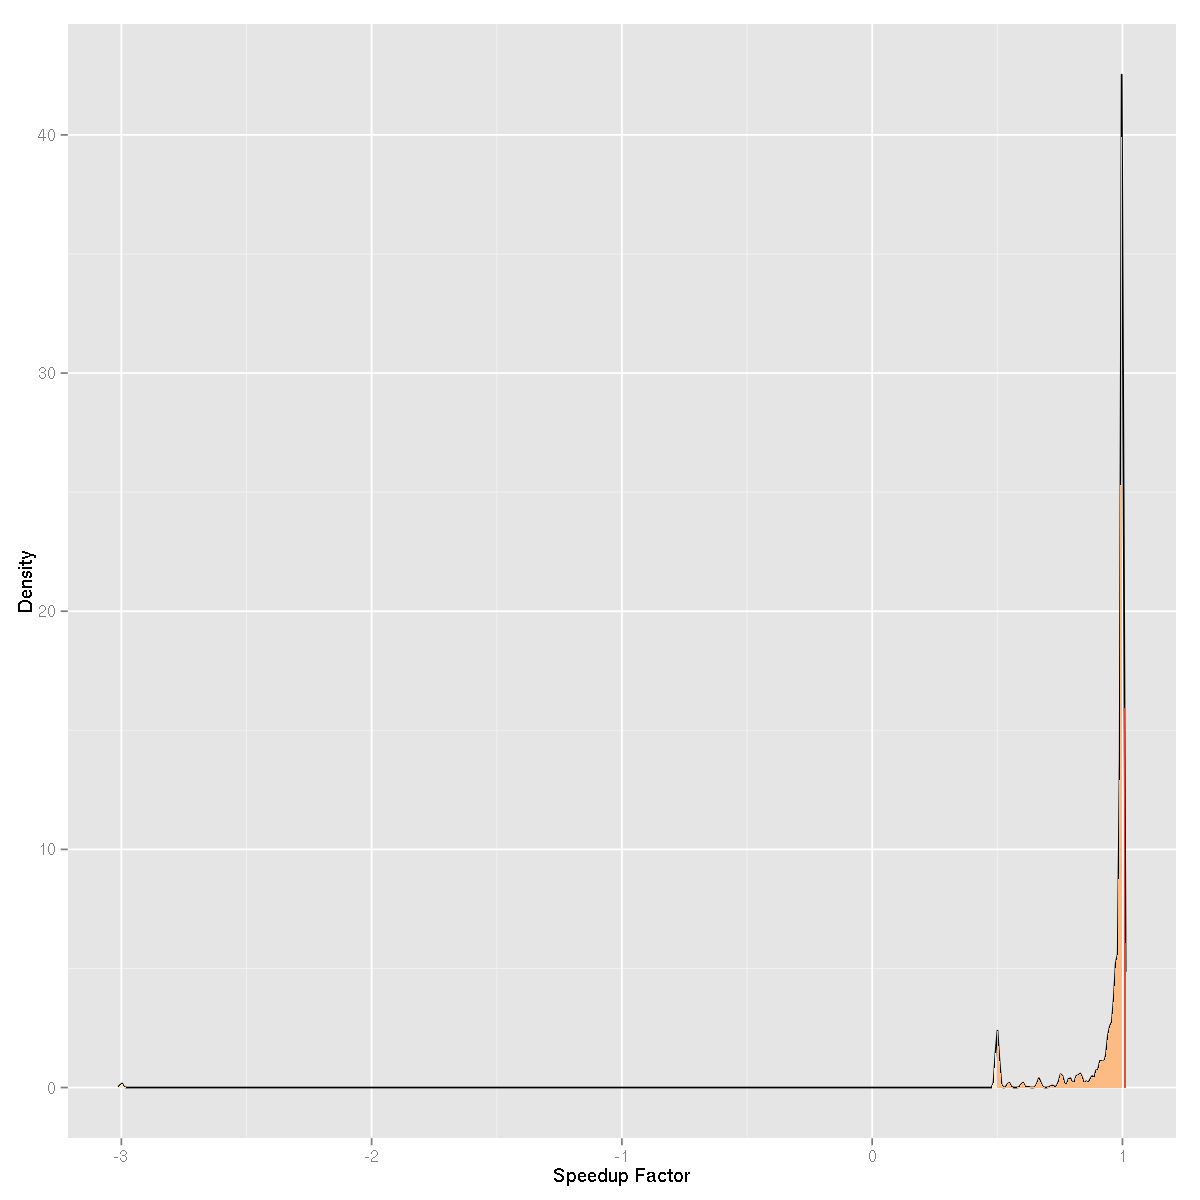

In [242]:
p <- ggplot(data=df.slower, aes(x=x, y=y)) +
    geom_line() +
    geom_ribbon(aes(ymin=0, ymax=y, fill=quant)) +
    scale_fill_brewer(guide="none", palette="OrRd") +
    xlab("Speedup Factor") +
    ylab("Density")
p

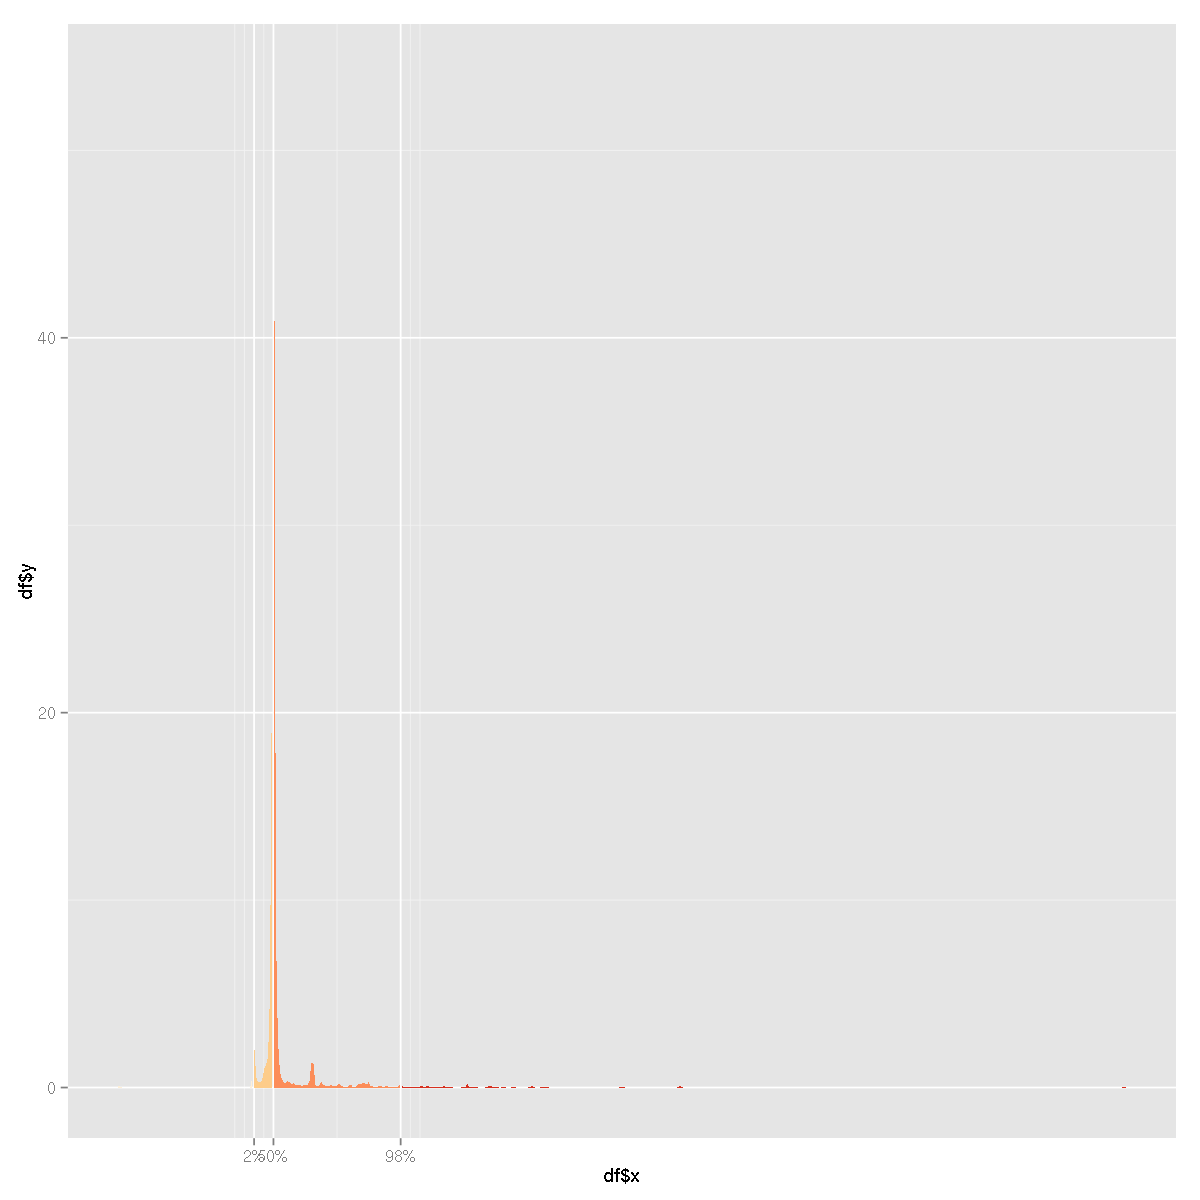

In [244]:
p <- ggplot(data=df, aes(x=df$x, y=df$y)) +
    #geom_line() +
    geom_ribbon(aes(ymin=0, ymax=y, fill=quant)) +
    #scale_x_log10(breaks = quantiles) +
    scale_x_continuous(breaks=quantiles) +
    scale_fill_brewer(guide="none", palette="OrRd")
    #geom_hline(yintercept=1, colour="blue", label = "baseline") +
    #geom_abline(slope=1, intercept=0, colour="green", label = "speedup") +
    #coord_cartesian(ylim=c(-10, 15)) +
    #scale_x_discrete() +
    #ylab("Speedup Factor")
    #+ geom_bar(aes(color = cores), stat = "identity")
    #+ geom_smooth(color = "red")
    #+ facet_wrap(~ project_name, ncol = 6) + xlab("Number of cores")
p